## Connect to your SAP HANA database

In [2]:
import os, hana_ml
print(hana_ml.__version__)

2.20.24042601


In [3]:
os.environ["HDB_USE_IDENT"]=os.getenv("WORKSPACE_ID")
print(os.getenv("HDB_USE_IDENT"))

workspaces-ws-cwf68


In [4]:
from hana_ml import dataframe as hdf

In [5]:
myconn=hdf.ConnectionContext(userkey='myDevChallenger')
print("SAP HANA DB version: ", myconn.hana_version())

SAP HANA DB version:  4.00.000.00.1718710788 (fa/CE2024.14)


Two open-source Python modules `geopandas` and `contextily` allow you to visualize results on a map in Jupyter notebook

In [7]:
import geopandas
import contextily as ctx

## Choose the SAP HANA graph workspace `AIRROUTES_DFH`

In [8]:
import hana_ml.graph

In [9]:
hana_ml.graph.discover_graph_workspaces(myconn)

,SCHEMA_NAME,WORKSPACE_NAME,IS_VALID,EDGE_TARGET_COLUMN,EDGE_SOURCE_COLUMN_NAME,EDGE_SCHEMA_NAME,EDGE_TABLE_NAME,EDGE_KEY_COLUMN_NAME,VERTEX_SCHEMA_NAME,VERTEX_TABLE_NAME,VERTEX_KEY_COLUMN_NAME
0,DEVCHALLENGER,AIRROUTES_DFH,TRUE,TO,FROM,DEVCHALLENGER,ROUTES_GE_VIEW,ID,DEVCHALLENGER,PORTS_GV_VIEW,ID


Create the [HANA Graph object](https://help.sap.com/doc/cd94b08fe2e041c2ba778374572ddba9/2024_2_QRC/en-US/hana_ml.graph.html#hana_ml.graph.Graph) in Python from an exisiting graph space in SAP HANA

In [12]:
hgws_airroutes=(
    hana_ml.graph.Graph(myconn, workspace_name='AIRROUTES_DFH')
)

## Create a HANA DataFrame with spatial "strings" for all connections 

In [13]:
hdf_ports=myconn.table("PORTS")
hdf_routes=myconn.table("ROUTES")

Method [`ST_MakeLine()`](https://help.sap.com/docs/hana-cloud-database/sap-hana-cloud-sap-hana-database-spatial-reference/st-makeline-method?version=2024_2_QRC&locale=en-US) creates a linestring from two given points.

In [28]:
hdf_routes_strings = (hdf_routes.alias('E1')
    .join(hdf_ports.alias('F'),'E1."FROM"=F."ID"', select=['E1.*',('NEW ST_POINT("LON", "LAT", 4326)','POINT_FROM')])
    .alias('E2')
    .join(hdf_ports.alias('T'),'E2."TO"=T."ID"', 
                            select=[('E2.ID','ID'), 'FROM', 'TO', 'DIST',
                                    ('ST_MakeLine("POINT_FROM", NEW ST_POINT("LON", "LAT", 4326))', 'LINE')]
))

hdf_routes_strings.head(3).collect()

,ID,FROM,TO,DIST,LINE
0,5141,1,51,4381,LINESTRING (-84.4281005859375 33.6366996765137...
1,5142,1,52,4600,LINESTRING (-84.4281005859375 33.6366996765137...
2,5175,1,161,5742,LINESTRING (-84.4281005859375 33.6366996765137...


## Shortest path...

...from **WRO** (Wrocław, Poland) to **GKA** (Goroka, Papua New Guinea) with the least number of hops using the built-in SAP HANA graph algorithms.

In [95]:
airport_code_from='HYD'
airport_code_to='ILM'

Find the vertex ID for the airport [IATA code](https://en.wikipedia.org/wiki/IATA_airport_code):

In [103]:
airport_id_from=hgws_airroutes.vertices_hdf.filter(f"CODE='{airport_code_from}'").select('ID').collect().values[0][0]
print(f"Vertex ID for the airport {airport_code_from}: {airport_id_from}")

Vertex ID for the airport HYD: 118


In [104]:
airport_id_to=hgws_airroutes.vertices_hdf.filter(f"CODE='{airport_code_to}'").select('ID').collect().values[0][0]
print(f"Vertex ID for the airport {airport_code_to}: {airport_id_to}")

Vertex ID for the airport ILM: 530


The package [hana_ml.graph.algorithms](https://help.sap.com/doc/cd94b08fe2e041c2ba778374572ddba9/2024_2_QRC/en-US/hana_ml.graph.algorithms.html) contains various algorithms you can use to explore and work on a graph.

In [105]:
import hana_ml.graph.algorithms as hga


Calculate `path_airport1_to_airport2_hops` ShortestPath object using the [`execute()`](https://help.sap.com/doc/cd94b08fe2e041c2ba778374572ddba9/2024_2_QRC/en-US/hana_ml.graph.algorithms.html#hana_ml.graph.algorithms.ShortestPath.execute) method...

In [106]:

path_airport1_to_airport2_hops = hga.ShortestPath(graph=hgws_airroutes).execute(
    source=str(airport_id_from),
    target=airport_id_to
)

...and see the results: 
* [vertices](https://help.sap.com/doc/cd94b08fe2e041c2ba778374572ddba9/2024_2_QRC/en-US/hana_ml.graph.algorithms.html#hana_ml.graph.algorithms.ShortestPath.vertices)
* [edges](https://help.sap.com/doc/cd94b08fe2e041c2ba778374572ddba9/2024_2_QRC/en-US/hana_ml.graph.algorithms.html#hana_ml.graph.algorithms.ShortestPath.edges)
* [weight](https://help.sap.com/doc/cd94b08fe2e041c2ba778374572ddba9/2024_2_QRC/en-US/hana_ml.graph.algorithms.html#hana_ml.graph.algorithms.ShortestPath.weight)

In [107]:

print("Vertices (airports to visit) in the order:\n", path_airport1_to_airport2_hops.vertices.set_index('VERTEX_ORDER'))
print("\nEdges (connections to use) in the order:\n", path_airport1_to_airport2_hops.edges.set_index('EDGE_ORDER'))
print("\nWeight (number of hops): ", int(path_airport1_to_airport2_hops.weight))


Vertices (airports to visit) in the order:
                ID
VERTEX_ORDER     
1             118
2             106
3              45
4             530

Edges (connections to use) in the order:
                ID  FROM   TO
EDGE_ORDER                  
1           18328   118  106
2           17100   106   45
3            8732    45  530

Weight (number of hops):  3


Preview the HANA DataFrame filter built from the vertices results:

In [108]:
hdf_ports.filter('ID IN ('+path_airport1_to_airport2_hops.vertices.ID.astype(str).str.cat(sep=', ')+')').select_statement

'SELECT * FROM (SELECT * FROM "PORTS") AS "DT_8" WHERE ID IN (118, 106, 45, 530)'

...and use it to create a GeoPandas dataframe `dfg_shortest_path_hops` to be used for visualization of airports on a map

In [111]:
dfg_shortest_path_hops = geopandas.GeoDataFrame(
    hdf_ports
    .filter('ID IN ('+path_airport1_to_airport2_hops.vertices.ID.astype(str).str.cat(sep=', ')+')')
    .select("ID", "CODE", "CITY", ("NEW ST_POINT(LON, LAT, 4326)", "POINT_LON_LAT_GEO")).collect(), 
    geometry='POINT_LON_LAT_GEO', crs="EPSG:4326"
)

In [112]:
dfg_shortest_path_hops

,ID,CODE,CITY,POINT_LON_LAT_GEO
0,45,PHL,Philadelphia,POINT (-75.2411 39.8719)
1,106,DOH,Doha,POINT (51.60806 25.27306)
2,118,HYD,Hyderabad,POINT (78.42986 17.23132)
3,530,ILM,Wilmington,POINT (-77.9026 34.2706)


...and use it to create a GeoPandas dataframe `dfg_shortest_path_string` to be used for visualization of a route on a map

In [113]:
dfg_shortest_path_string = geopandas.GeoDataFrame(
myconn.sql(
    hdf_routes_strings
        .filter('ID IN ('+path_airport1_to_airport2_hops.edges.ID.astype(str).str.cat(sep=',')+')')
        .agg([('ST_CollectAggr', 'LINE', 'LINE_PATH')])
        .select_statement).collect(), 
    geometry='LINE_PATH', crs="EPSG:4326"
)

Build and display the `fig_shortest_path` image.

Note the conversion of geospatial values from the Round-Earth 4326 to the [spatial reference `3857`](https://epsg.io/3857) used at the 2D maps. `3857` is sometimes refered to as [`900913`](https://epsg.io/900913), because of `GOOGLE` (used in Google Maps). Got it? 🤓

You use `OpenStreetMap.Mapnik` map provider, as it does not require an API key. For more information check: [https://contextily.readthedocs.io/en/latest/providers_deepdive.html#What-is-this-%22provider%22-object-?](https://contextily.readthedocs.io/en/latest/providers_deepdive.html#What-is-this-%22provider%22-object-?)

👉 Note that the first render might take quite a few seconds.

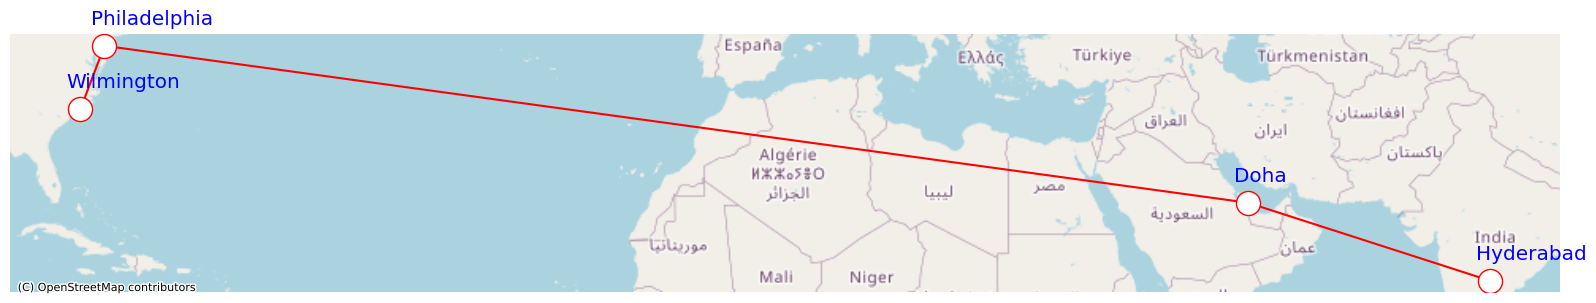

In [114]:
fig_shortest_path=dfg_shortest_path_hops.to_crs(epsg=3857).plot(
    figsize=(20, 15), zorder=3,
    alpha=1, color='w', edgecolor='r', markersize=300
)
fig_shortest_path.set_axis_off()

dfg_shortest_path_hops.to_crs(epsg=3857).apply(
    lambda port: fig_shortest_path.annotate(port.CITY, 
                                            xy=port.POINT_LON_LAT_GEO.coords[0], 
                                            xytext=(-10, 15), 
                                            textcoords="offset points",
                                            fontsize="x-large",
                                            color="b"
                                           ), axis=1
)

dfg_shortest_path_string.to_crs(epsg=3857).plot(ax=fig_shortest_path, alpha=1, edgecolor='r', zorder=1)

ctx.add_basemap(ax=fig_shortest_path, source=ctx.providers.OpenStreetMap.Mapnik)

## Shortest path (weighted)

...from **WRO** (Wrocław, Poland) to **GKA** (Goroka, Papua New Guinea) with the shortest distance.

Note the use of an additional `weight` attribute in the call specifying the use of the distance `DIST` attribute.

In [116]:
import hana_ml.graph.algorithms as hga

path_airport1_to_airport2_dist = hga.ShortestPath(graph=hgws_airroutes).execute(
    source=airport_id_from,
    target=airport_id_to,
    weight='DIST')

In [117]:
print("Vertices (airports to visit) in the order:\n", path_airport1_to_airport2_dist.vertices.set_index('VERTEX_ORDER'))
print("\nEdges (connections to use) in the order:\n", path_airport1_to_airport2_dist.edges.set_index('EDGE_ORDER'))
print("\nWeight (in distance): ", path_airport1_to_airport2_dist.weight)


Vertices (airports to visit) in the order:
                ID
VERTEX_ORDER     
1             118
2              59
3              35
4              45
5             530

Edges (connections to use) in the order:
                ID  FROM   TO
EDGE_ORDER                  
1           18323   118   59
2           11084    59   35
3            4893    35   45
4            8732    45  530

Weight (in distance):  8585.0


Create a GeoPandas dataframe `dfg_shortest_path_dist_hops` to be used for visualization of airports on a map

In [118]:
dfg_shortest_path_dist_hops = geopandas.GeoDataFrame(
    hdf_ports
    .filter('ID IN ('+path_airport1_to_airport2_dist.vertices.ID.astype(str).str.cat(sep=',')+')')
    .select("ID", "CODE", "CITY", ("NEW ST_POINT(LON, LAT, 4326)", "POINT_LON_LAT_GEO")).collect(), 
    geometry='POINT_LON_LAT_GEO', crs="EPSG:4326"
)

Create a GeoPandas dataframe `dfg_shortest_path_dist_string` to be used for visualization of a route on a map

In [119]:

dfg_shortest_path_dist_string = geopandas.GeoDataFrame(
myconn.sql(hdf_routes_strings
         .filter('ID IN ('+path_airport1_to_airport2_dist.edges.ID.astype(str).str.cat(sep=',')+')')
         .agg([('ST_UnionAggr', 'LINE', 'LINE_PATH')])
         .select_statement).collect(), geometry='LINE_PATH', crs="EPSG:4326")

Build and display the `fig_shortest_path_dist` image.

You use `OpenStreetMap.Mapnik` map provider, as it does not require an API key. For more information check: [https://contextily.readthedocs.io/en/latest/providers_deepdive.html#What-is-this-%22provider%22-object-?](https://contextily.readthedocs.io/en/latest/providers_deepdive.html#What-is-this-%22provider%22-object-?)

👉 Note that the first render might take quite a few seconds.

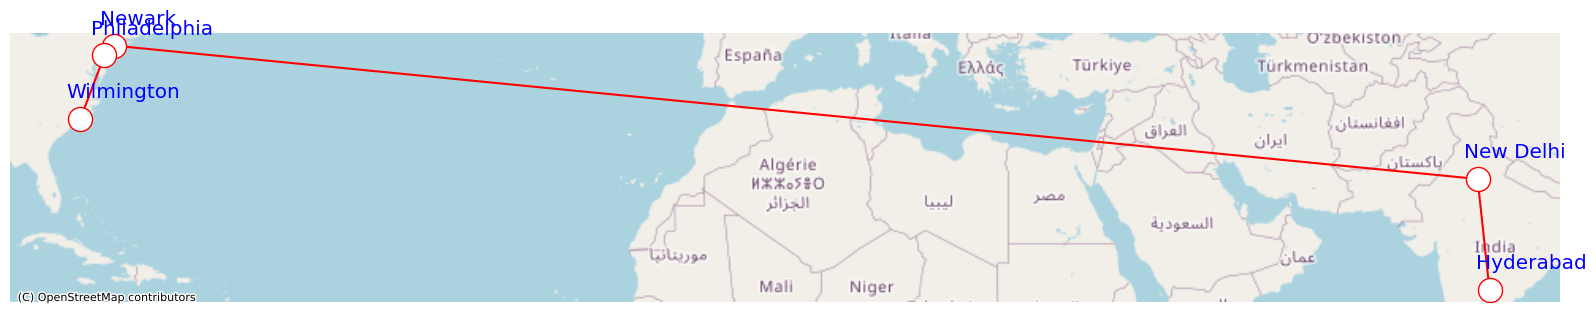

In [120]:
fig_shortest_path_dist=dfg_shortest_path_dist_hops.to_crs(epsg=3857).plot(
    figsize=(20, 15), zorder=3,
    alpha=1, color='w', edgecolor='r', markersize=300
)
fig_shortest_path_dist.set_axis_off()

dfg_shortest_path_dist_hops.to_crs(epsg=3857).apply(
    lambda port: fig_shortest_path_dist.annotate(port.CITY, 
                                            xy=port.POINT_LON_LAT_GEO.coords[0], 
                                            xytext=(-10, 15), 
                                            textcoords="offset points",
                                            fontsize="x-large",
                                            color="b"
                                           ), axis=1
)

dfg_shortest_path_dist_string.to_crs(epsg=3857).plot(ax=fig_shortest_path_dist, alpha=1, edgecolor='r', zorder=1)

ctx.add_basemap(ax=fig_shortest_path_dist, source=ctx.providers.OpenStreetMap.Mapnik)

### It's time for the submission!

Experiement with some other airport codes in variables `airport_code_from` and `airport_code_to` above to come up with your own example of the shortest path results and paste the screenshot of either shortest with the number of hops or shortest distance in the submission thread: https://community.sap.com/t5/application-development-discussions/submissions-for-quot-sap-hana-cloud-multi-model-quot-developer-challenge/m-p/13743532#M2028765